In [156]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , power_transform as PowerTransform
import numpy as np
from tqdm.notebook import trange, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc , roc_auc_score , confusion_matrix
from IPython.display import clear_output
import logging

In [157]:
PATH = "/home/advice/Python/SR/Data/Rain/weatherAUS.csv"
data = pd.read_csv(PATH)

In [158]:
data.shape

(142193, 24)

In [159]:
notuse = ["RISK_MM", "Date"]
d = data[notuse]

In [160]:
data = data.drop(notuse , axis = 1)

In [161]:
data.shape

(142193, 22)

In [162]:
target = data.pop("RainTomorrow")

In [163]:
target.head()

0    No
1    No
2    No
3    No
4    No
Name: RainTomorrow, dtype: object

In [164]:
objcol = data.select_dtypes("object").columns.tolist()

In [165]:
numcol = data.select_dtypes("float").columns.tolist()

In [166]:
ModelCol = numcol + objcol
total_dim = len(ModelCol)
data = data[ModelCol]

In [167]:
totalcol = data.columns.tolist()
objinfo = [idx for idx , col in enumerate(totalcol) if col in objcol ]

In [168]:
target = LabelEncoder().fit_transform(target)

In [169]:
train_X , test_X , train_Y , test_Y =\
train_test_split(data, target , test_size = 0.3 , stratify = target )

In [170]:
train_X.shape , train_Y.shape

((99535, 21), (99535,))

In [171]:
target

array([0, 0, 0, ..., 0, 0, 0])

In [172]:
test_X.shape , test_Y.shape

((42658, 21), (42658,))

In [173]:
train_X.head() , train_Y

(        MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
 11257      13.8     24.7       0.0          NaN       NaN           46.0   
 124038      9.2     17.0       0.0          NaN       NaN           22.0   
 90105      19.0     22.1       0.0          NaN       NaN           37.0   
 85477      14.5     27.2       0.0          4.8      10.6           35.0   
 49791       6.7     15.6       7.6          NaN       NaN           54.0   
 
         WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
 11257           19.0          31.0         55.0         53.0  ...   
 124038           6.0           4.0         81.0         62.0  ...   
 90105           19.0          17.0         89.0         48.0  ...   
 85477            0.0          19.0         64.0         58.0  ...   
 49791           22.0          15.0         58.0         41.0  ...   
 
         Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm      Location  \
 11257        1026.8       NaN       N

In [174]:
len(set(train_X["Location"].unique()) & set(test_X["Location"].unique()))

49

In [175]:
len(set(train_X["Location"].unique()) )

49

In [176]:
LabelEncoding = {}
for col in objcol :
    print(col)
    encoding = LabelEncoder()
    category = list(set(list(train_X[col].unique()) + [np.nan]))
    encoding.fit(category)
    train_X[col] = train_X[col].fillna('nan')
    train_X[col] = encoding.transform(train_X[col])
    LabelEncoding[col] = encoding

Location
WindGustDir
WindDir9am
WindDir3pm
RainToday


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 변형셋 모으기 

In [177]:
from time import time
start = time()
change = {}
for col in objcol :
    change[col] = {}
    LABLEncoder = LabelEncoding[col]
    unknownlabel = set(test_X[col].unique()).difference(set(LABLEncoder.classes_))
    c = dict(zip(unknownlabel , [np.nan] * len(unknownlabel)))
    c[np.nan] = 'nan'
    change[col] = c
    
print("{}초".format(time()- start))

0.023242950439453125초


In [178]:
for col in objcol :
    print(col)
    LABLEncoder = LabelEncoding[col]
    unknownlabel = set(test_X[col].unique()).difference(set(LABLEncoder.classes_))
    c = dict(zip(unknownlabel , [np.nan] * len(unknownlabel)))
    c[np.nan] = 'nan'
    test_X[col] = test_X[col].replace(c)   
    test_X[col] = LABLEncoder.transform(test_X[col])

Location
WindGustDir
WindDir9am
WindDir3pm
RainToday


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [179]:
train_X = train_X.astype(np.float32)
test_X = test_X.astype(np.float32)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler , StandardScaler
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(train_X[numcol])
train_X[numcol] = imp_mean.transform(train_X[numcol])
test_X[numcol] = imp_mean.transform(test_X[numcol])

In [180]:
for col in numcol :
    ck = np.sum(train_X[col] <= 0)
    if ck == 0 :
        print(col)
        train_X[col] = PowerTransform(train_X[col].values.reshape(-1,1),
                                      method = "box-cox")
        test_X[col] = PowerTransform(test_X[col].values.reshape(-1,1),
                                     method = "box-cox")

WindGustSpeed
Pressure9am


/root/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/root/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/root/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Pressure3pm


/root/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [181]:
robust = RobustScaler(quantile_range=(10.0, 90.0))
robust = StandardScaler()
robust.fit(train_X[numcol])
train_X[numcol] = robust.transform(train_X[numcol])
test_X[numcol] = robust.transform(test_X[numcol])

In [182]:
objdict = {}
for i in objinfo :
    objdict[i] = train_X.iloc[:, i].nunique()
objdict

{16: 49, 17: 17, 18: 17, 19: 17, 20: 3}

In [183]:
tf.reset_default_graph()
batch_size = tf.placeholder(tf.int64, name="Batchsize")
X =  tf.placeholder(tf.float32 , shape = [None , total_dim])
y = tf.placeholder(tf.float32 , [None])
dropoutRate = tf.placeholder(tf.float32, name ="dropoutRate")
InputdropoutRate = tf.placeholder(tf.float32, name ="InputdropoutRate")
#y = tf.string_to_number(y)
X , y 

(<tf.Tensor 'Placeholder:0' shape=(?, 21) dtype=float32>,
 <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>)

In [184]:
idx = objinfo[4]
split = tf.slice(X , [0 , idx ] ,
                 [batch_size , 1 ] )
split = tf.reshape(split , shape=(-1,))
split = tf.to_int32(split)
_len_ = objdict[idx]
_len_

3

In [185]:
def emb(split =None, _len_=None , n = None , ratio = None) :
    split = tf.reshape(split , shape=(-1,))
    split = tf.to_int32(split)
    if _len_ < n :
        first =  _len_
        to = _len_
        Cat = tf.one_hot(split ,depth=_len_)
    else :
        first =  _len_
        to = int(_len_/2)
        # 2/_len_
        embeddings = tf.Variable(tf.truncated_normal([first , to], 
                                                     stddev =  0.1 ) ,
                                 dtype = tf.float32)  
        Cat = tf.nn.embedding_lookup(embeddings, split)
        Cat = tf.nn.dropout(Cat , ratio)
    print("Onehot Shape : [{}] --> Embedding Shape : [{}] ".format(first , to))
    return Cat

def EmbeddingLayer(X , objdict, batch_size , inputratio ) :
    inputs = []
    for idx , (key, values )in enumerate(objdict.items()) :
        if idx == 0 :
            ## 1번째
            split = tf.slice(X , [0 , idx ] ,[batch_size , key] ) # 
            split = tf.nn.dropout(split , inputratio)
            inputs.append(split)
            category = tf.slice(X , [0 , key ] ,[batch_size , 1 ] )
            _len_ = values
            Cat = emb(category , _len_ , 4 , inputratio)
            inputs.append(Cat)
        else :
            split = tf.slice(X , [0 , key ] ,[batch_size , 1 ] )
            _len_ = values
            Cat = emb(split , _len_ , 4 , inputratio)
            inputs.append(Cat)
    concatenated_layer = tf.concat(inputs, axis=1, name='concatenate')
    return concatenated_layer

In [186]:
def tf_feature(X , objcol , objdict , batch_size , InputdropoutRate) :
    if objcol == [] :
        featureX = tf.nn.dropout(X , InputdropoutRate)
    else :
        featureX = EmbeddingLayer(X , objdict, batch_size , InputdropoutRate)
    return featureX

In [187]:
XX = tf_feature(X , objcol , objdict , batch_size , InputdropoutRate)

Onehot Shape : [49] --> Embedding Shape : [24] 
Onehot Shape : [17] --> Embedding Shape : [8] 
Onehot Shape : [17] --> Embedding Shape : [8] 
Onehot Shape : [17] --> Embedding Shape : [8] 
Onehot Shape : [3] --> Embedding Shape : [3] 


In [188]:
target_dim = len(np.unique(target))
target_dim

2

In [189]:
def tf_mish(x) :
    return x * tf.nn.tanh(tf.nn.softplus(x))
from tensorflow.contrib.layers import *
def get_weight_variable(shape, name=None,
                        type='xavier_uniform', regularize=True, **kwargs):
    initialise_from_constant = False
    if type == 'xavier_uniform':
        initial = xavier_initializer(uniform=True, dtype=tf.float32)
    elif type == 'xavier_normal':
        initial = xavier_initializer(uniform=False, dtype=tf.float32)
    elif type == 'he_normal':
        initial = variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'he_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'caffe_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=1.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'simple':
        stddev = kwargs.get('stddev', 0.02)
        initial = tf.truncated_normal(shape, stddev=stddev, dtype=tf.float32)
        initialise_from_constant = True
    elif type == 'bilinear':
        weights = _bilinear_upsample_weights(shape)
        initial = tf.constant(weights, shape=shape, dtype=tf.float32)
        initialise_from_constant = True
    else:
        raise ValueError('Unknown initialisation requested: %s' % type)

    if name is None:  # This keeps to option open to use unnamed Variables
        weight = tf.Variable(initial)
    else:
        if initialise_from_constant:
            weight = tf.get_variable(name, initializer=initial)
        else:
            weight = tf.get_variable(name, shape=shape, initializer=initial)
    if regularize:
        tf.add_to_collection('weight_variables', weight)
    return weight 

def Network(X , dims , dropoutRate) :
    with tf.variable_scope("Network"):
        for idx , h_dim in enumerate(dims) :
            init = tf.keras.initializers.lecun_normal(seed = 1234 + idx)
            if idx == 0 :    
                TOTAL_DIM = XX.get_shape().as_list()[1]
                Weight =get_weight_variable(shape = [TOTAL_DIM , h_dim], name="W"+str(idx),
                                    type='xavier_normal', regularize=True)
#                 Weight = tf.get_variable("W" + str(idx) , dtype = tf.float32 , 
#                                          shape = [TOTAL_DIM , h_dim] , initializer = init)
                Bias = tf.get_variable("Bias" + str(idx) ,
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                Layer = tf.nn.selu(tf.matmul( X , Weight) + Bias)
                Layer = tf.contrib.nn.alpha_dropout(Layer , dropoutRate ) 
            else :
#                 Weight = tf.get_variable("W" + str(idx) , dtype = tf.float32 , 
#                                          shape = [dims[idx-1] ,h_dim ] , initializer = init)
                Weight =get_weight_variable(shape = [dims[idx-1] ,h_dim ], 
                                            name="W"+str(idx),
                                            type='xavier_normal', regularize=True)
                Bias = tf.get_variable("Bias" + str(idx) ,
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                Layer = tf.matmul( Layer , Weight) + Bias
                if len(dims) == idx+1 :pass
                else : 
                    Layer = tf.nn.selu(Layer)
                    Layer = tf.contrib.nn.alpha_dropout(Layer , dropoutRate ) 
    return Layer


In [190]:
Logit = Network(XX , dims = [55 , 40 , 35 , 10 , target_dim] , dropoutRate=dropoutRate)
Probs = tf.nn.softmax(Logit)

## Label Smoothing

In [191]:
alpha = 0.95
y_one_hot = tf.add(alpha* tf.one_hot( tf.cast(y , tf.int32) , depth=target_dim) ,
                   (1-alpha) / target_dim)

In [192]:
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
pd.DataFrame(sess.run(XX , feed_dict ={ X : train_X.values ,
                                       batch_size : 1 , 
                                       InputdropoutRate : 0.9
                                      }))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: TITAN X (Pascal), pci bus id: 0000:04:00.0, compute capability: 6.1



,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0.279576,0.232992,-0.308601,-2.160952e-08,5.004391e-08,0.616969,0.62296,1.57158,-0.813044,0.0,...,-0.004253,0.067238,0.035231,0.127263,-0.085512,-0.194128,0.179249,1.0,0.0,0.0


In [193]:
pd.DataFrame(sess.run(Logit , feed_dict ={ X : train_X.values ,
                                          batch_size : 1,
                                          InputdropoutRate : 0.8 ,
                                          dropoutRate : 0.8
                                         }))

,0,1
0,0.033937,-1.614929


In [194]:
pd.DataFrame(sess.run(y_one_hot , feed_dict ={ y : train_Y , batch_size : 1})).head(1)

,0,1
0,0.975,0.025


In [195]:
from sklearn.utils.class_weight import compute_class_weight
y_weight_info = compute_class_weight(class_weight= "balanced" , 
                     classes = np.unique(train_Y),
                     y= np.squeeze(train_Y))
weight = tf.constant([ y_weight_info[1] ] ) #
WCE = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
                                               logits = Logit , 
                                               pos_weight =  weight)

In [196]:
Loss = tf.reduce_mean(WCE)

In [197]:
vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Network")

In [198]:
WEIGHTS = tf.get_collection("weight_variables")
import re 
L2 = []
for v in WEIGHTS :
    L2.append(tf.nn.l2_loss(v))
Loss += tf.add_n(L2)  * 0.0001
# l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
# regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, WEIGHTS )
# Loss += regularization_penalty


In [199]:
solver = tf.train.AdamOptimizer(learning_rate= 2e-5).minimize(Loss ,var_list = vars )

In [200]:
target_0_list = []
target_1_list = []
_=[target_1_list.append(idx) if i == 1 else target_0_list.append(idx) for idx , i in enumerate(list(train_Y))]

In [201]:
np.random.permutation([1,2,3,4,5,4,3])

array([3, 4, 5, 1, 4, 2, 3])

I0105 15:38:47.194380 140713105065728 <ipython-input-202-3ee84b636d33>:67] Epoch : 1700 argmax
I0105 15:38:47.195420 140713105065728 <ipython-input-202-3ee84b636d33>:68] [[26053  7042]
 [ 2547  7016]]


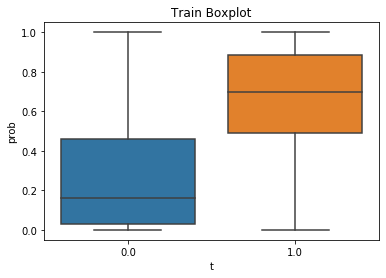

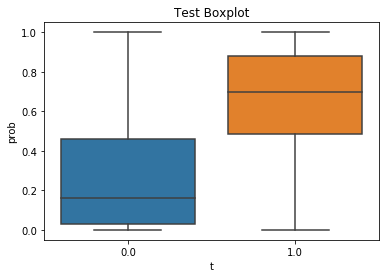

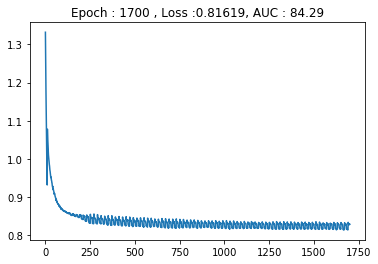

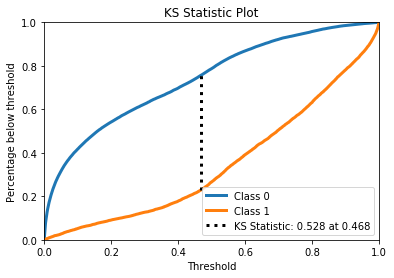

I0105 15:38:48.210268 140713105065728 <ipython-input-202-3ee84b636d33>:89] Epoch : 1700 change
I0105 15:38:48.211511 140713105065728 <ipython-input-202-3ee84b636d33>:90] [[25037  8058]
 [ 2188  7375]]
I0105 15:39:00.888108 140713105065728 <ipython-input-202-3ee84b636d33>:53] Epoch : 1710  Boosting List : 10174
I0105 15:39:14.516105 140713105065728 <ipython-input-202-3ee84b636d33>:53] Epoch : 1720  Boosting List : 5925
I0105 15:39:27.184625 140713105065728 <ipython-input-202-3ee84b636d33>:53] Epoch : 1730  Boosting List : 10227
I0105 15:39:42.335347 140713105065728 <ipython-input-202-3ee84b636d33>:53] Epoch : 1740  Boosting List : 5952
I0105 15:39:54.818200 140713105065728 <ipython-input-202-3ee84b636d33>:53] Epoch : 1750  Boosting List : 10107


In [ ]:
_Loss_ = []
Epoch= 50000
mb_size = 500
import scikitplot as skplt
print("Train")
log = logging.getLogger('TF_log')
log.setLevel(logging.DEBUG)
fileHandler = logging.FileHandler('./tf_log.txt' , mode= "w")
log.addHandler(fileHandler)

config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
for epoch in trange(Epoch , desc = "Loop" ) :
    idx = list(np.random.permutation(len(train_X)))
    if (epoch > 0 ) & (epoch > 10) :
        idx = idx + BoostingList
        idx = list(np.random.permutation(idx))
        mb_size = 1000
    else : 
        mb_size = 500
    XX = train_X.iloc[idx, : ].values
    YY = train_Y[idx]
    batch_iter = int(len(XX) / mb_size)
    _Loss2_ = []
    for idx in range(batch_iter) :
        X_mb = XX[idx*mb_size:(idx+1)*mb_size]
        Y_mb = YY[idx*mb_size:(idx+1)*mb_size]
        Feed = {X : X_mb ,
                y : Y_mb , 
                batch_size : mb_size , 
                InputdropoutRate : 0.8 ,
                dropoutRate : 0.8
               }
        _ , LOSS  = sess.run([solver , Loss] , feed_dict= Feed)
        _Loss2_.append(LOSS)
    _Loss_.append(np.mean(_Loss2_))
    if (epoch > 0 ) & (epoch % 10 == 0) :
        Feed = { X : train_X.values ,
                batch_size : len(train_X.values) ,
                InputdropoutRate : 0.8 ,
                dropoutRate : 0.8
               }
        probs  = sess.run(Probs , feed_dict= Feed)
        trainDD = pd.DataFrame([train_Y ,probs[:,1]],
                          index = ["t","prob"]).T
        ### Target 1 Boosting List
        DD2 = trainDD[(trainDD.t == 1) & (trainDD.prob <0.5)]
        BoostingList = 3 * DD2.index.tolist()
        msg = "Epoch : {}  Boosting List : {}".\
              format(epoch,len(DD2.index.tolist()))
        log.info(msg)
    if (epoch > 0)  & (epoch % 100 == 0) :
        Feed = { X : test_X.values ,
                batch_size : len(test_X.values) ,
                InputdropoutRate : 0.8 ,
                dropoutRate : 0.8
               }
        probs  = sess.run(Probs , feed_dict= Feed)
        AUC = roc_auc_score(test_Y ,  probs[:,1])
        DD = pd.DataFrame([test_Y ,probs[:,1]],
                          index = ["t","prob"]).T
        
        clear_output()
        msg = confusion_matrix(test_Y , np.argmax(probs,axis =1) )
        log.info("Epoch : {} argmax".format(str(epoch)))
        log.info(msg)
        msg = "Epoch : {} , Loss :{:.5f}, AUC : {:.2f}".format(epoch ,LOSS ,AUC*100)
        sns.boxplot(x="t", y="prob", data=trainDD)
        plt.title("Train Boxplot")
        plt.savefig("./NN_Train_Boxplot.png")
        plt.show()
        sns.boxplot(x="t", y="prob", data=DD)
        plt.title("Test Boxplot")
        plt.savefig("./NN_Test_Boxplot.png")
        plt.show()
        plt.plot(np.arange(len(_Loss_)), _Loss_ )
        plt.title(msg)
        plt.savefig("./NN_LOSS_Plot.png")
        plt.show()        
        pp = skplt.metrics.plot_ks_statistic(test_Y, probs)
        plt.savefig("./NN_KS_Plot.png")
        plt.show()
        b , c = pp.get_legend_handles_labels()
        threshold = float(c[2].split("at ")[1])
        aaa = np.where( probs[:,1] < threshold , 0 , 1 )
        msg = confusion_matrix(test_Y , aaa )
        log.info("Epoch : {} change".format(str(epoch)))
        log.info(msg)

In [ ]:
import os , re
import smtplib
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
login = '#########@gmail.com'
password = '############'
sender_email = login
receiver_email = login
msg = MIMEMultipart('SendMail')
msg['Subject'] = "Train Complete"
msg['From'] = sender_email
msg['To'] = receiver_email
text = "학습 완료! 체크!"
part2 = MIMEText(text)
msg.attach(part2)
static = os.getcwd()
img_path = [os.path.join(static, i) for i in os.listdir(static) if re.search("NN_" , i ) ]
for ImgFileName in img_path :
    img_data = open(ImgFileName, 'rb').read()
    image = MIMEImage(img_data, name=os.path.basename(ImgFileName))
    msg.attach(image)    
filename = "text.txt"
import codecs
filename = os.path.join(static ,"tf_log.txt" )
f = codecs.open(filename, 'rb', 'utf-8')
attachment = MIMEText(f.read())
attachment.add_header('Content-Disposition', 'attachment', filename="tf_log.txt")           
msg.attach(attachment)
with smtplib.SMTP_SSL("smtp.gmail.com") as server:
    server.login(login, password)
    server.sendmail(sender_email,
                    receiver_email,
                    msg.as_string())
print('Sent') 